# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

![line of pine trees](images/trees.jpg)

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [1]:
# Run this cell without changes
import pandas as pd

df = pd.read_csv('data/forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [2]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
0    35754
1     2747
Name: Cover_Type, dtype: int64

Percentages
0    0.928651
1    0.071349
Name: Cover_Type, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, for this lab you will be focusing on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [3]:
# Your code here
from sklearn.model_selection import train_test_split

target = 'Cover_Type'
y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify=y)

Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [4]:
# Your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

The following code checks that everything is set up correctly:

In [5]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [6]:
# Replace None with appropriate code

# Relevant imports
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsClassifier 

# Creating the model
knn_baseline_model = KNeighborsClassifier()

## do I fit? NO
#knn_baseline_model.fit(X_train_scaled, y_train) 

## Get cross_val_scores
cv_results = cross_val_score(
    knn_baseline_model,  # current model
    X_train_scaled, # X data to use
    y_train, 
    scoring='neg_log_loss'
) ## could add .mean() and combine next step into this one step

## Get the mean
cv_mean = cv_results.mean()

# Perform cross-validation
## remember to negate negative  
knn_baseline_log_loss = -cv_mean

knn_baseline_log_loss

0.1255288892455634

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [7]:
# Replace None with appropriate text
"""
SPEED: The cross validation took a while to run, I am not sure if my laptop is slow or if that is how long it 
takes to cross validate this amount of data. 

METRICS: With log loss, smaller is better so in this case our log loss of .125 is better than our best logistic
regression model of .130.

Is this model better? I would say yes that this baseline knn model is better than our logistic regression model. 
However, the crossvalidation part of establishing its superiority is less than ideal. I would want to find a better (quicker)
way of measuring this models performance.
"""
print()

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

In [8]:
# Your code here (add more cells as needed)

# get baseline parameters that were used in this model
knn_baseline_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### 3A. Change `weights='distance'`

In [9]:
# Creating the model
knn_weights = KNeighborsClassifier(weights='distance')

## Change this to do all in one line
# Perform cross-validation 
knn_weights_log_loss = -cross_val_score(knn_weights,  X_train_scaled, y_train, \
                                         scoring='neg_log_loss').mean()

knn_weights_log_loss

0.12226739703628035

**NOTES:** Slight improvement, from .1255 to .1223

### 3B. With `weights='distance'` use a for loop to find best number of k neighbors 


In [10]:
# Your code here (add more cells as needed)
best_k = 0 # keep track of current best score
best_log_loss = 1.0 # keep track of current best score

for k in [1,25,50,75]:
    # Instantiate KNeighborsClassifier
    knn = KNeighborsClassifier(weights='distance', n_neighbors=k)
    
    # Perform cross-validation
    log_loss = -cross_val_score(knn, X_train_scaled, y_train, \
                                         scoring='neg_log_loss').mean()
    # assign best values
    if log_loss < best_log_loss:
        best_log_loss = log_loss
        best_k = k
        
print(f'Best k: {best_k}\nBest log loss score: {best_log_loss}')

Best k: 25
Best log loss score: 0.05616502147205423


**NOTES:** Big improvement from knn_weights model of .1223 to .0562 

### 3C. WITHOUT `weights='distance'` use a for loop to find best number of k neighbors 

In [11]:
best_k = 0 # keep track of current best score
best_log_loss = 1.0 # keep track of current best score

for k in [1,25,50,75]:
    # Instantiate KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation
    log_loss = -cross_val_score(knn, X_train_scaled, y_train, \
                                         scoring='neg_log_loss').mean()
    # assign best values
    if log_loss < best_log_loss:
        best_log_loss = log_loss
        best_k = k
        
print(f'Best k: {best_k}\nBest log loss score: {best_log_loss}')

Best k: 25
Best log loss score: 0.06425722742416393


**NOTES:** Using default weight parameter (removing weights='distance') resulted in a higher log loss.

Current best model is: `KNeighborsClassifier(weights='distance', n_neighbors=25)` with a log loss of 0.056165

### 3D. Adjust `leaf_size`
`leaf_size` default is 30, I will -+ 20 in both directions with a step size of 10. I will keep current best paramaters as I for loop through leaf_sizes

In [12]:
current_best_model = KNeighborsClassifier(weights='distance', n_neighbors=25)
current_best_log_loss = 0.05616502147205423

In [13]:
best_leaf_size = 30 # keep track of current best score

for leaf_size in [10,20,40,50]:
    # Instantiate KNeighborsClassifier
    knn = KNeighborsClassifier(weights='distance', n_neighbors=25, leaf_size=leaf_size)
    
    # Perform cross-validation
    log_loss = -cross_val_score(knn, X_train_scaled, y_train, \
                                         scoring='neg_log_loss').mean()
    # assign best values
    if log_loss < current_best_log_loss:
        current_best_log_loss = log_loss
        best_leaf_size = leaf_size
        
print(f'Best leaf size: {best_leaf_size}\nBest log loss score: {best_log_loss}')

Best leaf size: 30
Best log loss score: 0.06425722742416393


**NOTES:** `leaf_size` default value of 30 is best.

`current_best_model` remains `KNeighborsClassifier(weights='distance', n_neighbors=25)`

### 3E. Change `p=1` 

When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2.

In [14]:
knn_p1 = KNeighborsClassifier(weights='distance', n_neighbors=25, p=1)

# Perform cross-validation
log_loss_p1 = -cross_val_score(knn_p1, X_train_scaled, y_train, \
                                     scoring='neg_log_loss').mean()
log_loss_p1

0.057770545147750915

**NOTES:** Changing power parameter from 2 to 1 increased the log loss slightly.

`current_best_model` remains `KNeighborsClassifier(weights='distance', n_neighbors=25)`

## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [15]:
# Your code here
from sklearn.tree import DecisionTreeClassifier

# Instantiate DecisionTreeClassifier
dt_base = DecisionTreeClassifier(random_state=45)

# Perform cross-validation 
dt_base_log_loss = -cross_val_score(dt_base,  X_train_scaled, y_train, \
                                         scoring='neg_log_loss').mean()

print(f'Baseline Decision Tree Classifer log loss: {dt_base_log_loss}')

Baseline Decision Tree Classifer log loss: 0.6913810510118484


Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

In [16]:
# Replace None with appropriate text
"""
Wow that was fast! The log loss score is much higher (worse) but the speed of calculating is almost instant. 
Decision trees are known for overfitting so it is likely the terrible score is a result of this tendency.
"""

'\nWow that was fast! The log loss score is much higher (worse) but the speed of calculating is almost instant. \nDecision trees are known for overfitting so it is likely the terrible score is a result of this tendency.\n'

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

In [17]:
# First get baseline parameters that were used in this model
dt_base.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 45,
 'splitter': 'best'}

**NOTES:** Before adjusting things like `class_weight` and `criterion`, I should prune the tree first. Use for loops to find best values on `max_depth`, `max_features`, and `min_samples_split`

### 5A. Use `X_train` (instead of `X_train_scaled`)

In [18]:
dt_NOT_scaled = DecisionTreeClassifier(random_state=45)

# Perform cross-validation 
dt_NOT_scaled_log_loss = -cross_val_score(dt_NOT_scaled,  X_train, y_train, \
                                         scoring='neg_log_loss').mean()

dt_NOT_scaled_log_loss

0.6877925513277068

**NOTES:** Not using scaled data improved the score: from 0.691 to 0.688

### 5B. Adjust `max_depth`

Best Log Loss: 0.1123665727154893 with `max_features=6`


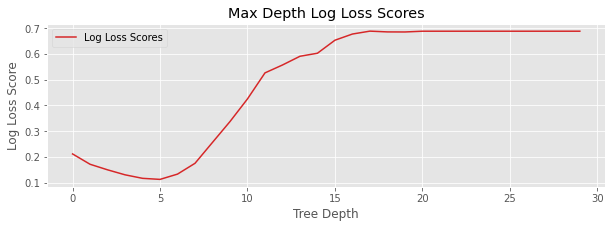

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

max_d = 0 
depth_log_loss = 1
depth_scores = []

for max_depth in range(1, 31):
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=45)
    log_loss = -cross_val_score(dt, X_train, y_train, scoring='neg_log_loss').mean()
    depth_scores.append(log_loss)
    if log_loss < depth_log_loss:
        max_d = max_depth
        depth_log_loss = log_loss
print(f'Best Log Loss: {depth_log_loss} with `max_features={max_d}`')

plt.figure(figsize=(10, 3))
plt.plot(depth_scores, c='tab:red', label='Log Loss Scores')
plt.title('Max Depth Log Loss Scores')
plt.xlabel('Tree Depth')
plt.ylabel('Log Loss Score')
plt.legend();

**NOTES:** Best Log Loss: 0.1123665727154893 with `max_features=6`

### 5C. Adjust `max_features`

Best Log Loss: 0.10775255346043314 with `max_features=33`


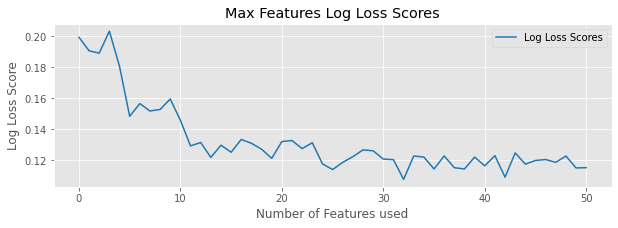

In [20]:
max_feat = 0
min_feature_log_loss = 1
feature_scores = []

for max_features in range(1, len(X_train.columns)):
    dt = DecisionTreeClassifier(max_depth=6, max_features=max_features, random_state=45)
    log_loss = -cross_val_score(dt, X_train, y_train, scoring='neg_log_loss').mean()
    feature_scores.append(log_loss)
    if log_loss < min_feature_log_loss:
        max_feat = max_features
        min_feature_log_loss = log_loss
print(f'Best Log Loss: {min_feature_log_loss} with `max_features={max_feat}`')

plt.figure(figsize=(10, 3))
plt.plot(feature_scores, c='tab:blue', label='Log Loss Scores')
plt.title('Max Features Log Loss Scores')
plt.xlabel('Number of Features used')
plt.ylabel('Log Loss Score')
plt.legend();

**NOTES:** Best Log Loss: 0.10775255346043314: 
- `max_features=33` 
- `max_features=6`

### 5E. Adjust  `min_samples_leaf`

Best Log Loss: 0.10601832371676138 with `min_samples_leaf=91`


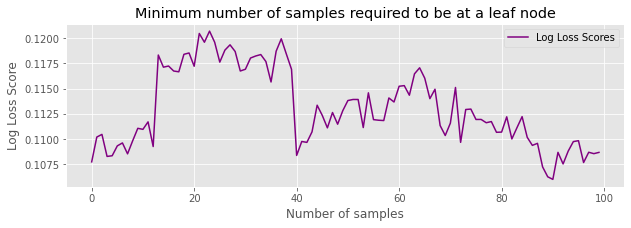

In [21]:
min_samples = 0
min_leaf_log_loss = 1
feature_scores = []

for min_samples_leaf in range(1,101):
    dt = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=min_samples_leaf, random_state=45)
    log_loss = -cross_val_score(dt, X_train, y_train, scoring='neg_log_loss').mean()
    feature_scores.append(log_loss)
    if log_loss < min_leaf_log_loss:
        min_samples = min_samples_leaf
        min_leaf_log_loss = log_loss
print(f'Best Log Loss: {min_leaf_log_loss} with `min_samples_leaf={min_samples}`')

plt.figure(figsize=(10, 3))
plt.plot(feature_scores, c='purple', label='Log Loss Scores')
plt.title('Minimum number of samples required to be at a leaf node')
plt.xlabel('Number of samples')
plt.ylabel('Log Loss Score')
plt.legend();

**NOTES:** Best Log Loss: 0.10601832371676138:
- `min_samples_leaf=91`
- `max_features=33` 
- `max_features=6`

### 5E. Adjust `class_weight`

In [22]:
dt_weighted = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 1.1, 1: 1}, random_state=45)
 
dt_weighted_log_loss = -cross_val_score(dt_weighted, X_train, y_train, scoring='neg_log_loss').mean()

dt_weighted_log_loss

0.10555331580715019

In [23]:
dt_weighted = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 1.2, 1: 1}, random_state=45)
 
dt_weighted_log_loss = -cross_val_score(dt_weighted, X_train, y_train, scoring='neg_log_loss').mean()

dt_weighted_log_loss

0.10618444913278802

In [24]:
dt_weighted = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 1.2, 1: 1.1}, random_state=45)
 
dt_weighted_log_loss = -cross_val_score(dt_weighted, X_train, y_train, scoring='neg_log_loss').mean()

dt_weighted_log_loss

0.10543104856973777

In [25]:
dt_weighted = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 11.9, 1: 11}, random_state=45)
 
dt_weighted_log_loss = -cross_val_score(dt_weighted, X_train, y_train, scoring='neg_log_loss').mean()

dt_weighted_log_loss

0.10542866021762423

In [26]:
dt_weighted = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 11.8, 1: 11}, random_state=45)
 
dt_weighted_log_loss = -cross_val_score(dt_weighted, X_train, y_train, scoring='neg_log_loss').mean()

dt_weighted_log_loss

0.10540826282101032

In [27]:
dt_weighted = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 11.8, 1: 11.1}, random_state=45)
 
dt_weighted_log_loss = -cross_val_score(dt_weighted, X_train, y_train, scoring='neg_log_loss').mean()

dt_weighted_log_loss

0.10539377794030076

In [28]:
dt_weighted = DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 118.1, 1: 111}, random_state=45)
 
dt_weighted_log_loss = -cross_val_score(dt_weighted, X_train, y_train, scoring='neg_log_loss').mean()

dt_weighted_log_loss

0.1053703553452329

**NOTES:** Acknowledging that was a very ugly way to do that but it was faster in the moment to do by hand and not for loop with several if statements

lowest I can get log loss is 0.1053703553452329, with `DecisionTreeClassifier(max_depth=6, max_features=33, min_samples_leaf=91, class_weight={0: 118.1, 1: 111}, random_state=45)`

### 5F. Change `criterion='entropy'`

In [29]:
dt_entropy = DecisionTreeClassifier(criterion='entropy', 
                                    max_depth=6, 
                                    max_features=33, 
                                    min_samples_leaf=91, 
                                    class_weight={0: 118.1, 1: 111}, 
                                    random_state=45)

dt_entropy_log_loss = -cross_val_score(dt_entropy, X_train, y_train, scoring='neg_log_loss').mean()

dt_entropy_log_loss

0.12188302364470043

**NOTES:** This raised the log loss

## 5.5 Compare

In [30]:
best_dt_model = DecisionTreeClassifier(max_depth=6, 
                                       max_features=33, 
                                       min_samples_leaf=91, 
                                       class_weight={0: 118.1, 1: 111}, 
                                       random_state=45)
best_dt_log_loss = 0.1053703553452329

best_knn_model = KNeighborsClassifier(weights='distance', n_neighbors=25)
best_knn_log_loss = 0.05616502147205423

## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [31]:
# Replace None with appropriate code
final_model = best_knn_model

# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=25, weights='distance')

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [32]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))

log loss:  0.07383619156608083
accuracy:  0.977456887596094
precision: 0.9122807017543859
recall:    0.7569141193595342


In [33]:
# reminder of what 'dummy' model (that always chooses the majority class) would look like
print(f'Dummy model would be {(y.value_counts(normalize=True)[0])*100}% accurate, \
\nand have an error rate of {(y.value_counts(normalize=True)[1])*100}%')

Dummy model would be 92.86512038648347% accurate, 
and have an error rate of 7.1348796135165315%


### Previous logistic regression Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [34]:
# Replace None with appropriate text
"""
This current best model out performed both logistic regression and dummy models. The time is takes
to run the model you save in tinkering. I fould optimal parameter is half the time with 
KNeighborsClassifier vs DecisionTreeClassifier. 
"""
print()

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.